## 1. LeNet-5
- 합성곱과 다운샘풀링을 반복적으로 거치면서 마지막에 완전연결층에서 분류를 수행

In [1]:
#1) 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch.autograd import Variable
from torch import optim #경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os #파일 경로에 대한 함수들을 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행 상황을 가시적으로 표현,
import random
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
#2) 이미제 데이터셋전처리
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform={
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale =(0.5,1,0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]), #.Compose : 이미지 처리 묶음. (리사이즈 -> 플립 -> 텐서화 -> 정규화)
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img) #클래스를 호출할 수 있도록 하는 메소드. 인스터스가 호출 되었을때 실행
    

In [31]:
#3) 훈련용으로 400개의 이미지, 검증용으로 92개의 이미지, 테스트용으로 열 개의 이미지 사용
cat_directory = r'../ch6/ch6 data/dogs-vs-cats/Cat/'
dog_directory = r'../ch6/ch6 data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f)for f in os.listdir(cat_directory)]) #고양이 이미지 데이터를 가져옴
dog_images_filepaths = sorted([os.path.join(dog_directory, f)for f in os.listdir(dog_directory)]) #개 이미지 데이터를 가져옴
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] #두 이미지를 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] #이미지파일들을 불러온다

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] #훈련용 400개의 이미지
val_images_filepaths = correct_images_filepaths[400:-10] #검증용 92의 이미지
test_images_filepaths = correct_images_filepaths[-10:] #테스트용 열 개의 이미지
print(len(train_images_filepaths),len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [75]:
#4) 테스트 데이터셋 이미지 확인 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #이미지 색생을 변경. 채널을 변경한다
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #이미지 전체 경로를 정규화 후 분할
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image) #개별 이미지를 출력
        ax.ravel()[i].set_title(predicted_label, color=color) #predicted_label을 타이틀로 사용
        ax.ravel()[i].set_axis_off() #이미지 축 제거
    plt.tight_layout() #이미지 여백 조정
    plt.show()

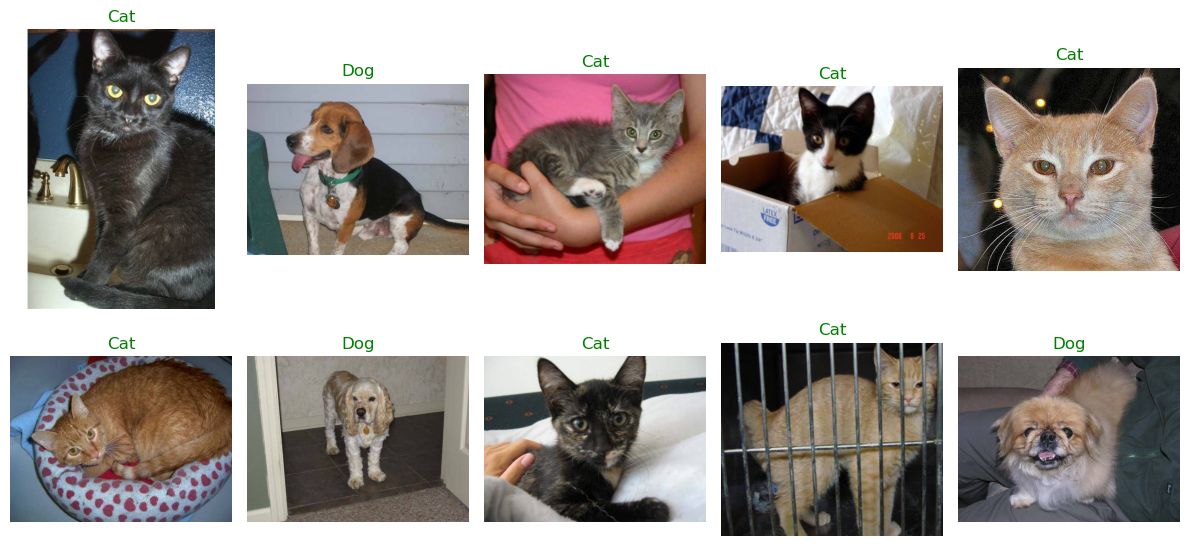

In [76]:
#5) 테스트 데이터셋 이미지 출력

display_image_grid(test_images_filepaths)

In [34]:
#6) 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase = 'train'): #데이터셋의 전처리
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self): #images_filepaths 데이터셋의 전체 길이를 반환
        return len(self.file_list)
    
    def __getitem__(self, idx): #데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태가 됨
        img_path = self.file_list[idx]
        img = Image.open(img_path) #img_path 위치에서 이미지 데이터를 가져옴
        img_transformed = self.transform(img, self.phase) #이미지에 train 전처리 사용
        label = img_path.split('/')[-1].split('.')[0] #이미지 데이터에 대한 레이블 값을 가져옴
        if label == 'dog' :
            label = 1
        elif label == 'cat' :
            label = 0
        return img_transformed, label

In [35]:
#7) 변수값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [36]:
#8) 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size,mean,std), phase = 'val')
index =0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1]) #훈련데이터 레이블 출력

torch.Size([3, 224, 224])
0


In [37]:
#9) 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) #배치 관리를 담당. 데이터를 그룹으로 쪼개서 조금씩 불러옴
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader} #훈련. 검증데이터 합쳐서 표현

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)


torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1])


In [49]:
#10)모델의 네트워크 클래스
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding = 0) #2D 합성곱층이 적용
        #입력은 (3,224,224) 출력은 (16,220,220) 
        self.relu1=nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #최대풀링 적용. 이후 출력은 (16,110,110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #출력형태는 (32,106,106)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) #출력:(32,53,53)
        self.fc1 = nn.Linear(32*53*53,512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512,2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0),-1) #완전연결층에 데이터를 전달하기 위해 데이터 형태를 1차원으로 바꾼다
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [50]:
#11) 모델 객체 생성
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [51]:
#12) torchsummary 라이브러리를 이용한 모델의 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [52]:
#13) 학습 가능한 파라미터 수 확인
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [54]:
#14) 옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #경사하강법으로 모멘텀 SGD를 사용
criterion = nn.CrossEntropyLoss()

In [55]:
#15) 모델의 파라미터와 손실함수를 CPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [64]:
#16) 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch) :
    since = time.time()
    best_acc = 0.0
    #반복
    for epoch in range(num_epoch): 
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)
        
        for phase in ['train','val']:
            if phase == 'train' :
                model.train() #모델을 학습시키겠다는 의미
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            #해당 데이터 로더의 데이터 배치에 대해 반복
            for inputs, labels in tqdm(dataloader_dict[phase]): 
                #입력데이터 이동
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad() #gradient 0으로 초기화
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) #모델은 입력 데이터와 합께 호출
                    _, preds = torch.max(outputs,1) #예측 라벨은 저절한 치수를 따라 최댓값을 취함으로써 얻음
                    #_은 변수 이름은 사용되지 않거나 의도적으로 무시되는 값. 반환 값 중 하나에만 관심 있거나 특정값이 안필요하면 사용
                    loss = criterion(outputs, labels) #손실함수를 이용한 오차 계산
                    
                    if phase == 'train':
                        loss.backward() #모델의 학습 가능한 모든 파라미터에 대해 기울기 계산
                        optimizer.step() #optimizer의 step 함수를 호출하면 파라미터 갱신
                    epoch_loss += loss.item() * inputs.size(0) #criterion인 크로스엔트로피는 애초에 평균이라 input.size를 곱해준다
                    epoch_corrects += torch.sum(preds == labels.data) #최종 오차계산
                    
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc :
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    
        time_elapsed = time.time() - since
        print('Traning complete in {:.0f}m {:.0f}s'.format(
                time_elapsed//60, time_elapsed%60))
        print('Best val Acc: {:4f}'.format(best_acc))
        return model

In [65]:
#17)모델 학습
import time
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\lockd\AppData\Local\Temp\ipykernel_18980\3226684720.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0563 Acc: 0.0375
train Loss: 0.0545 Acc: 0.0875
train Loss: 0.0560 Acc: 0.1200
train Loss: 0.0573 Acc: 0.1525
train Loss: 0.0559 Acc: 0.1950
train Loss: 0.0565 Acc: 0.2275
train Loss: 0.0561 Acc: 0.2700
train Loss: 0.0566 Acc: 0.3100
train Loss: 0.0534 Acc: 0.3650
train Loss: 0.0565 Acc: 0.3975
train Loss: 0.0568 Acc: 0.4375
train Loss: 0.0545 Acc: 0.4825
train Loss: 0.0277 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.2423 Acc: 0.1630
val Loss: 0.2476 Acc: 0.3587
val Loss: 0.2137 Acc: 0.5109
Traning complete in 0m 16s
Best val Acc: 0.510870


In [72]:
#18) 모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad(): #역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타냄
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase = 'val') #테스트 데이터셋 전처리 적용
        img = img.unsqueeze(0) # 텐서에 차원을 추가할 때 사용. (0)은 차원이 추가될 위치를 의미한다. (0)이면  (3)인 텐서가 (1,3)이됨
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:,1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        
res = pd.DataFrame({
    'id':id_list,
    'label':pred_list
}) #테스트 데이터셋의 예측 결과인 id와 레이블을 데이터 프레임에 저장
        
res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)
        
res.to_csv('../ch6/ch6 data/LeNet',index=False)

C:\Users\lockd\AppData\Local\Temp\ipykernel_18980\2848026118.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
#19) 테스트 데이터셋의 예측 결과 호출
res.head(10)

,id,label
0,109,0.482172
1,145,0.474649
2,15,0.533142
3,162,0.519678
4,167,0.564425
5,200,0.513932
6,210,0.583786
7,211,0.542003
8,213,0.524191
9,224,0.492055


In [85]:
#20) 테스트 데이터셋 이미지를 출력하기 위한 함수 정의
#1. 클래스 정의
class_ = classes = {0:'cat',1:'dog'} #개와 고양이에 대한 클래스 정의
#2. 그리드 생성
def display_image_grid(images_filepaths, predicted_lavels = (), cols=5):
    rows = len(images_filepaths) // cols
    figures, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 6))
    
    #3. 파일 차례로 불러오기
    for i, image_filepaths in enumerate(images_filepaths):
        image = cv2.imread(image_filepaths)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #랜덤하게 데이터 가져오기
        a = random.choice(res['id'].values) #데이터 프레임의 id라는 칼럼에서 임의로 데이터를 가져옴
        #예측값의 id와 라벨의 값을 가져온다
        label = res.loc[res['id']==a, 'label'].values[0]
        #라벨이 0.5보다 크면 개, 작으면 고양이
        if label>0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image) #사진 보여주기
        ax.ravel()[i].set_title(class_[label]) #레이블다기
        ax.ravel()[i].set_axis_off() #축 없애기

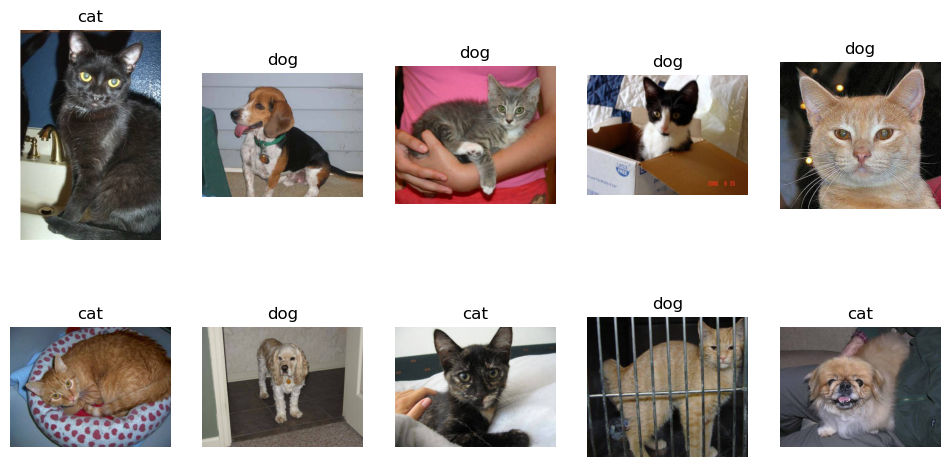

In [86]:
display_image_grid(test_images_filepaths)